# Feature Engineering

This Notebook shows the feature engineering part only. It displays, what features are most important which should be taken for the model prediction.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc  # grarbage collection
import time
import seaborn as sns
import random
random.seed(42)
import warnings # for not showing warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Reload function is used for read the data. First it will collect the garbage values from the memory. Then read the csv file. Then check the NaN(Not a Number) or invlaid values in target variable.

In [32]:
def reload():
    gc.collect()
    df = pd.read_csv('C://Users//ROHIT//PUBG placement prediction//train.csv')
    invalid_match_ids = df[df['winPlacePerc'].isna()]['matchId'].values
    df = df[-df['matchId'].isin(invalid_match_ids)]
    return df

# Corelation

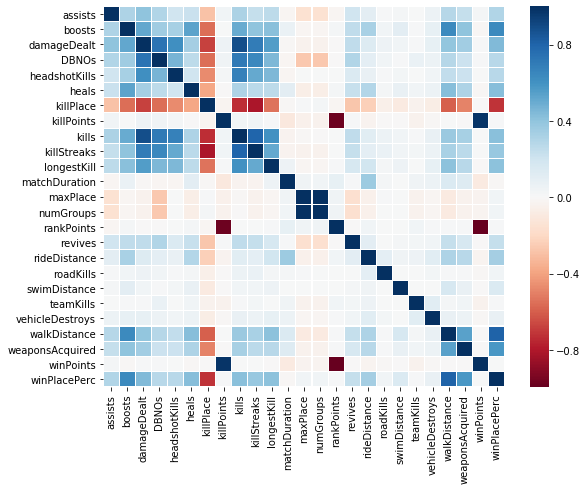

In [33]:
df = reload()
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']  # feature that are not useful for the target variable.So we have to remove these features.
cols_to_fit = [col for col in df.columns if col not in cols_to_drop] # features that are used for fit the model.
corr = df[cols_to_fit].corr() # create a matrix of corelation beatween the features.

plt.figure(figsize=(9,7))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linecolor='white',linewidths=0.1,cmap='RdBu') # cmap -> mapping from data values to color space.
plt.show()

The features which are in white color that are not corelated with target varible as you see in the graph. The features are in red color denotes that, they are negatively corelated and the feature are in blue color, they are positivley corelated to each other.

# Feature Creation

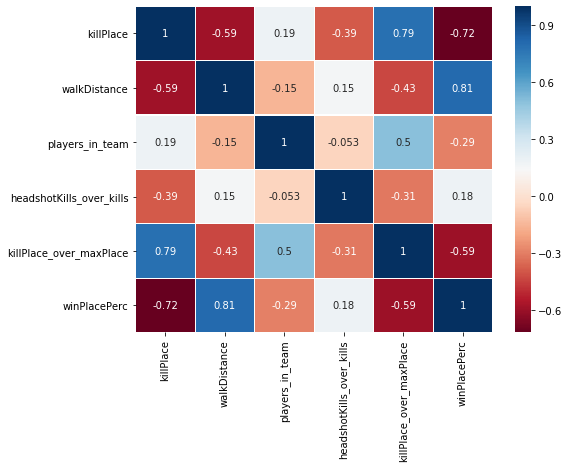

In [34]:
agg = df.groupby(['groupId']).size().to_frame('players_in_team')
df = df.merge(agg, how='left', on=['groupId'])
df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
df['headshotKills_over_kills'].fillna(0, inplace=True)  #replace NaN values with 0
df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
df['killPlace_over_maxPlace'].fillna(0, inplace=True)
df['killPlace_over_maxPlace'].replace(np.inf,0,inplace=True)  #  replace no.inf -> positive infinity values with 0
corr = df[['killPlace', 'walkDistance', 'players_in_team','headshotKills_over_kills', 'killPlace_over_maxPlace', 'winPlacePerc']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values,annot=True,linecolor='white',linewidths=0.1,cmap='RdBu') # annot is used for the values given between 1 and -1. if the feature are from 10 to 0 then they are not more important as the feature from 10 to 1 and -1.
plt.show()

# Score gain on a simple model

I used LinearRegression during feature engineering since it's simple and fast. It'd be enough if you just want to see the impact of the new feature you added.
It isbetter to split dataset by match  since we predict results by group in match.

In [35]:
def train_test_split(df, test_size=0.1):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1-test_size))
    train_match_ids = random.sample(match_ids, train_size)
    
    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

run_experiments method takes preprocess functions and returns DataFrame.

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def run_experiment(preprocess):    # main function
    df = reload()  # read dataset
    df.drop(columns=['matchType'], inplace=True)  # drop the matchType column because it is a catagorical feature
    
    df = preprocess(df)  
    
    target = 'winPlacePerc'
    cols_to_drop = ['Id', 'groupId', 'matchId', target]  # drop thefeatures
    cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
    train, val = train_test_split(df, 0.1)
    
    model = LinearRegression()
    model.fit(train[cols_to_fit], train[target])
    
    y_true = val[target]
    y_pred = model.predict(val[cols_to_fit])
    return mean_absolute_error(y_true, y_pred)

def run_experiments(preprocesses):
    result = []
    for preprocess in preprocesses:
        start = time.time()
        score = run_experiment(preprocess)
        execution_time = time.time() - start
        result.append({
            'name': preprocess.__name__,
            'score': score,
            'execution time' : f'{round(execution_time, 2)}s'
        })
        gc.collect()
        
        return pd.DataFrame(result, columns=['name','score','execution time']).sort_values(by='score')

Let's see player-level generated features

In [37]:
def original(df):
    return df

def item(df):   # create a new feature which is the combination of heals and boosts. Do the same for 2 or 3 features and chech accuracy.
    df['items'] = df['heals'] + df['boosts']
    return df

def players_in_team(df):
    agg = df.groupby(['groupId']).size().to_frame('players_in_team')
    return df.merge(agg, how = 'left', on=['groupId'])

def total_distance(df):
    df['total_distance'] = df['rideDistance'] + df['swimDistance'] + df['walkDistance']
    return df

def headshotKills_over_kills(df):
    df['headshotKills_over_kills'] = df['headshotKills'] / df['kills']
    df['headshotKills_over_kills'].fillna(0, inplace =true)
    return df

def killPlace_over_maxPlace(df):
    df['killPlace_over_maxPlace'] = df['killPlace'] / df['maxPlace']
    df['killPlace_over_maxPlace'].fillna(0, inplace=True)
    df['killPlace_over_maxPlace'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_heals(df):
    df['walkDistance_over_heals'] = df['walkDistance'] / df['heals']
    df['walkDistance_over_heals'].fillna(0, inplace=True)
    df['walkDistance_over_heals'].replace(np.inf, 0, inplace=True)
    return df

def walkDistance_over_kills(df):
    df['walkDistance_over_kills'] = df['walkDistance'] / df['kills']
    df['walkDistance_over_kills'].fillna(0, inplace=True)
    df['walkDistance_over_kills'].replace(np.inf, 0, inplace=True)
    return df

def teamwork(df):
    df['teamwork'] = df['assists'] + df['revives']
    return df

In [38]:
run_experiments([
    original, item, players_in_team, total_distance, headshotKills_over_kills, killPlace_over_maxPlace, walkDistance_over_heals, walkDistance_over_kills, teamwork
])

,name,score,execution time
0,original,0.092412,240.7s


Let's see aggregated features

In [39]:
def min_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['','_min'], how='left', on=['matchId','groupId'])

def max_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['','_max'], how='left', on=['matchId','groupId'])

def sum_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['','_sum'], how='left', on=['matchId','groupId'])

def median_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['','_median'], how='left', on=['matchId','groupId'])

def mean_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    return df.merge(agg, suffixes=['','_mean'], how='left', on=['matchId','groupId'])

def rank_by_team(df):
    cols_to_drop = ['Id','groupId', 'matchId', 'winPlacePerc']
    features = [col for col in df.columns if col not in cols_to_drop]
    agg = df.groupby(['matchId','groupId'])[features].min()
    agg = agg.groupby('matchId')[features].rank(pct=True)
    return df.merge(agg, suffixes=['','_mean_rank'], how='left', on=['matchId','groupId'])

In [40]:
run_experiments([
    original, min_by_team, max_by_team, sum_by_team, median_by_team, mean_by_team, rank_by_team
])

,name,score,execution time
0,original,0.092493,206.72s


You can see how important ran features are in this competition.

# Feature importance of Tree Model

Tree models can output feature importances.

[20]	valid_0's l1: 0.0650023
[40]	valid_0's l1: 0.0615301
[60]	valid_0's l1: 0.0603022
[80]	valid_0's l1: 0.0595901
[100]	valid_0's l1: 0.0591313


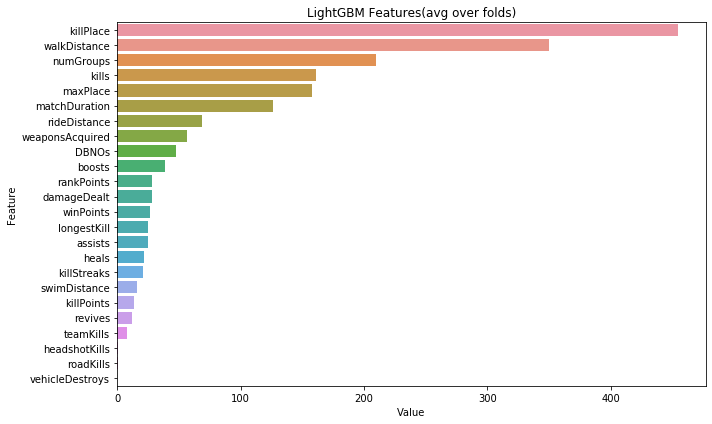

In [44]:
df = reload()

df.drop(columns=['matchType'], inplace=True)

target = 'winPlacePerc'
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType', target]
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
train, val = train_test_split(df, 0.1)

from lightgbm import LGBMRegressor
params ={
    'n_estimators':100,
    'learning_rate':0.3,
    'num_leaves':20,    #it is used in tree models
       
    'metric':'mae', # mae -> mean absolute error
    'verbose': -1,
}

model = LGBMRegressor(**params)
model.fit(
    train[cols_to_fit], train[target],
    eval_set=[(val[cols_to_fit], val[target])],
    eval_metric= 'mae',
    verbose=20,
)

feature_importance = pd.DataFrame(sorted(zip(model.feature_importances_, cols_to_fit)),columns=['Value','Feature'])

plt.figure(figsize=(10,6))
sns.barplot(x='Value', y='Feature', data=feature_importance.sort_values(by='Value', ascending=False))
plt.title('LightGBM Features(avg over folds)')
plt.tight_layout()

# Permutation importance

The basic idea is that observing how much the score decreases when a feature is not available; the method is known as "Permutation importance" or "Mean Decrease Accuracy(MDA)".

In [46]:
import eli5  
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=42).fit(val[cols_to_fit], val[target])
eli5.show_weights(perm, feature_names=list(cols_to_fit))  # weights show the importance of the feature and tell the loss or gain in the score.

Weight,Feature
1.6308 ± 0.0049,killPlace
0.3235 ± 0.0023,kills
0.3134 ± 0.0014,walkDistance
0.0819 ± 0.0003,numGroups
0.0435 ± 0.0003,maxPlace
0.0285 ± 0.0004,matchDuration
0.0284 ± 0.0003,killStreaks
0.0066 ± 0.0001,rideDistance
0.0059 ± 0.0001,boosts
0.0049 ± 0.0001,weaponsAcquired


In this table it will show the importance of the features by looking at their weights.